<a href="https://colab.research.google.com/github/navkapil/googlecolab/blob/master/ManpreetOnDemandPowerPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
# plotly
#!pip install chart_studio
import chart_studio.plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
#init_notebook_mode(connected=True)
import plotly.graph_objs as go
# Standard ML Models for comparison
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Splitting data into training/testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# Distributions
import scipy

In [ ]:
df = pd.read_csv('1.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
datetime,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


In [ ]:
df = df.drop(['Global_reactive_power','Voltage','Global_intensity','Sub_metering_1','Sub_metering_2','Sub_metering_3','Sub_metering_4'],axis=1)

&lt;matplotlib.axes._subplots.AxesSubplot at 0x19c0addd188&gt;

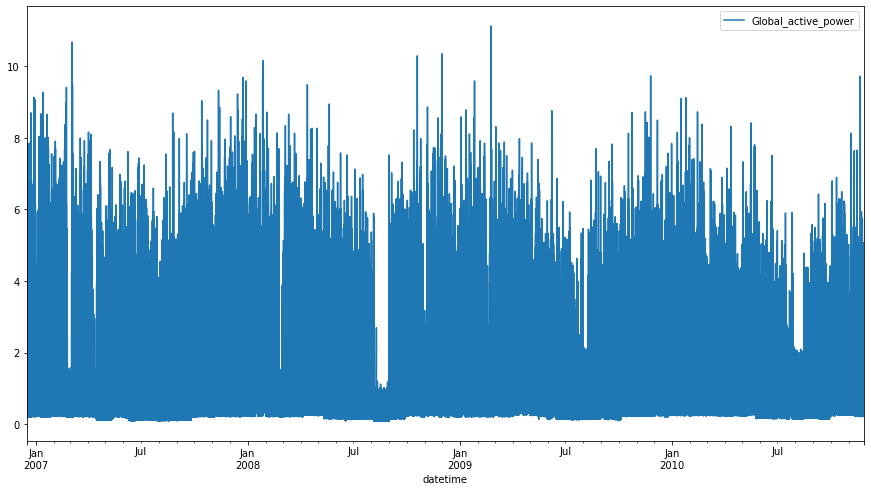

In [ ]:
df.plot(figsize=(15,8))

In [ ]:
# splitting the data into training and testing data (90% and 10%)
# we mention the random state to achieve the same split everytime we run the code
X_train, X_test, y_train, y_test = train_test_split(df, df['Global_active_power'], test_size = 0.10, random_state=42) #what columns keep target value? --Kapil

In [ ]:
from sklearn import preprocessing
# Normalizing Dataset
std_scale = preprocessing.StandardScaler().fit(X_train)
x_train_norm = std_scale.transform(X_train)

#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm,index=X_train.index, columns=X_train.columns) 
X_train.update(training_norm_col)
print (X_train.head())

                     Global_active_power
datetime                                
2007-10-24 17:06:00            -0.697185
2008-05-17 08:49:00             0.344075
2007-07-29 21:24:00            -0.867883
2010-01-24 21:38:00             0.103200
2010-03-05 15:59:00             0.683575


In [ ]:
X_train #X_train has timestamp, why only these two columns are taken?--kapil

,Global_active_power
datetime,
2007-10-24 17:06:00,-0.697185
2008-05-17 08:49:00,0.344075
2007-07-29 21:24:00,-0.867883
2010-01-24 21:38:00,0.103200
2010-03-05 15:59:00,0.683575
...,...
2007-06-14 17:02:00,-0.742704
2009-08-24 22:58:00,2.557462
2007-03-18 08:16:00,0.973762


In [ ]:
# Normalizing Testing Dataset
x_test_norm = std_scale.transform(X_test)
testing_norm_col = pd.DataFrame(x_test_norm, index=X_test.index, columns=X_test.columns) 
X_test.update(testing_norm_col)
print (X_test.head())

                     Global_active_power
datetime                                
2010-07-07 18:10:00            -0.790121
2007-05-14 06:50:00            -0.590973
2007-09-26 18:10:00            -0.314062
2007-06-19 07:30:00             0.190446
2010-05-10 04:43:00            -0.627009


In [ ]:
X_test

,Global_active_power
datetime,
2010-07-07 18:10:00,-0.790121
2007-05-14 06:50:00,-0.590973
2007-09-26 18:10:00,-0.314062
2007-06-19 07:30:00,0.190446
2010-05-10 04:43:00,-0.627009
...,...
2007-06-25 13:28:00,-0.835640
2008-04-15 19:30:00,-0.776844
2009-05-18 14:29:00,-0.636492


In [ ]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))

    return mae, rmse

In [ ]:
# find the median
median_pred = X_train['Global_active_power'].median()

# create a list with all values as median
median_preds = [median_pred for _ in range(len(X_test))]

# store the true G3 values for passing into the function
true = X_test['Global_active_power'] #isn't true a keyword in python? --Kapil

In [ ]:
# Display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true) #What is the need of this baseline? --Kapil
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

Median Baseline  MAE: 0.7362
Median Baseline RMSE: 1.1041


In [ ]:
#linear Regression

regressor = LinearRegression().fit(X_train, y_train)

y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

1.0
1.6031130085546705e-28


In [ ]:
#ElasticNet Regression
regressor = ElasticNet(alpha=0.1, l1_ratio=1.0).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.9890236621943387
0.010035223863217632


In [ ]:
#Random Forest Regression
regressor = RandomForestRegressor(n_estimators=50).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.999999991408993
9.586362626529772e-09


In [ ]:
#ExtraTrees Regression
regressor = ExtraTreesRegressor(n_estimators=150).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.999999999907933
1.027342706739172e-10


In [ ]:
#Suppport Vector Regression
regressor = SVR(kernel='rbf', degree=3, C=100, gamma=0.1).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))
# linear:- score 0.9934689389870804
# mean_squared_error 0.0070262635041696

0.9973159186609292
0.003072720980098993


In [ ]:
#Gradient Boosting Regression
regressor = GradientBoostingRegressor(n_estimators=50)  .fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.9998569772655139
0.0001575676809254067


In [ ]:
#Ada Boosting Regression
regressor = AdaBoostRegressor(n_estimators = 1000, random_state = 42).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.9929491404867701
0.007646129434180298


In [ ]:
#Decision Tree Regression
regressor = DecisionTreeRegressor(random_state = 42).fit(X_train, y_train)
from sklearn.metrics import r2_score
y_train_pred=regressor.predict(X_test)
print(r2_score(y_train_pred, y_test))
print(mean_squared_error(y_train_pred, y_test))

0.9999999972879345
3.0263045729587374e-09
